In [155]:
import pandas as pd

df_combined = pd.read_csv("mens_all_time_2019.csv")

df_combined["total_votes"] = df_combined["upvotes"] + df_combined["downvotes"]
df_combined["ratio"] = df_combined["upvotes"] / df_combined["total_votes"]
df_combined["inverse_order"] = df_combined.shape[0] - df_combined["order"].rank()
df_combined["bayes"] = (df_combined["upvotes"] + df_combined["upvotes"].median()) / (
    df_combined["upvotes"]
    + df_combined["upvotes"].median()
    + df_combined["downvotes"]
    + df_combined["downvotes"].median()
)

In [156]:
df_combined = df_combined[
    (df_combined["upvotes"] != 0) & (df_combined["downvotes"] != 0)
]
df_combined = df_combined[
    df_combined["total_votes"] >= df_combined["total_votes"].median()
]

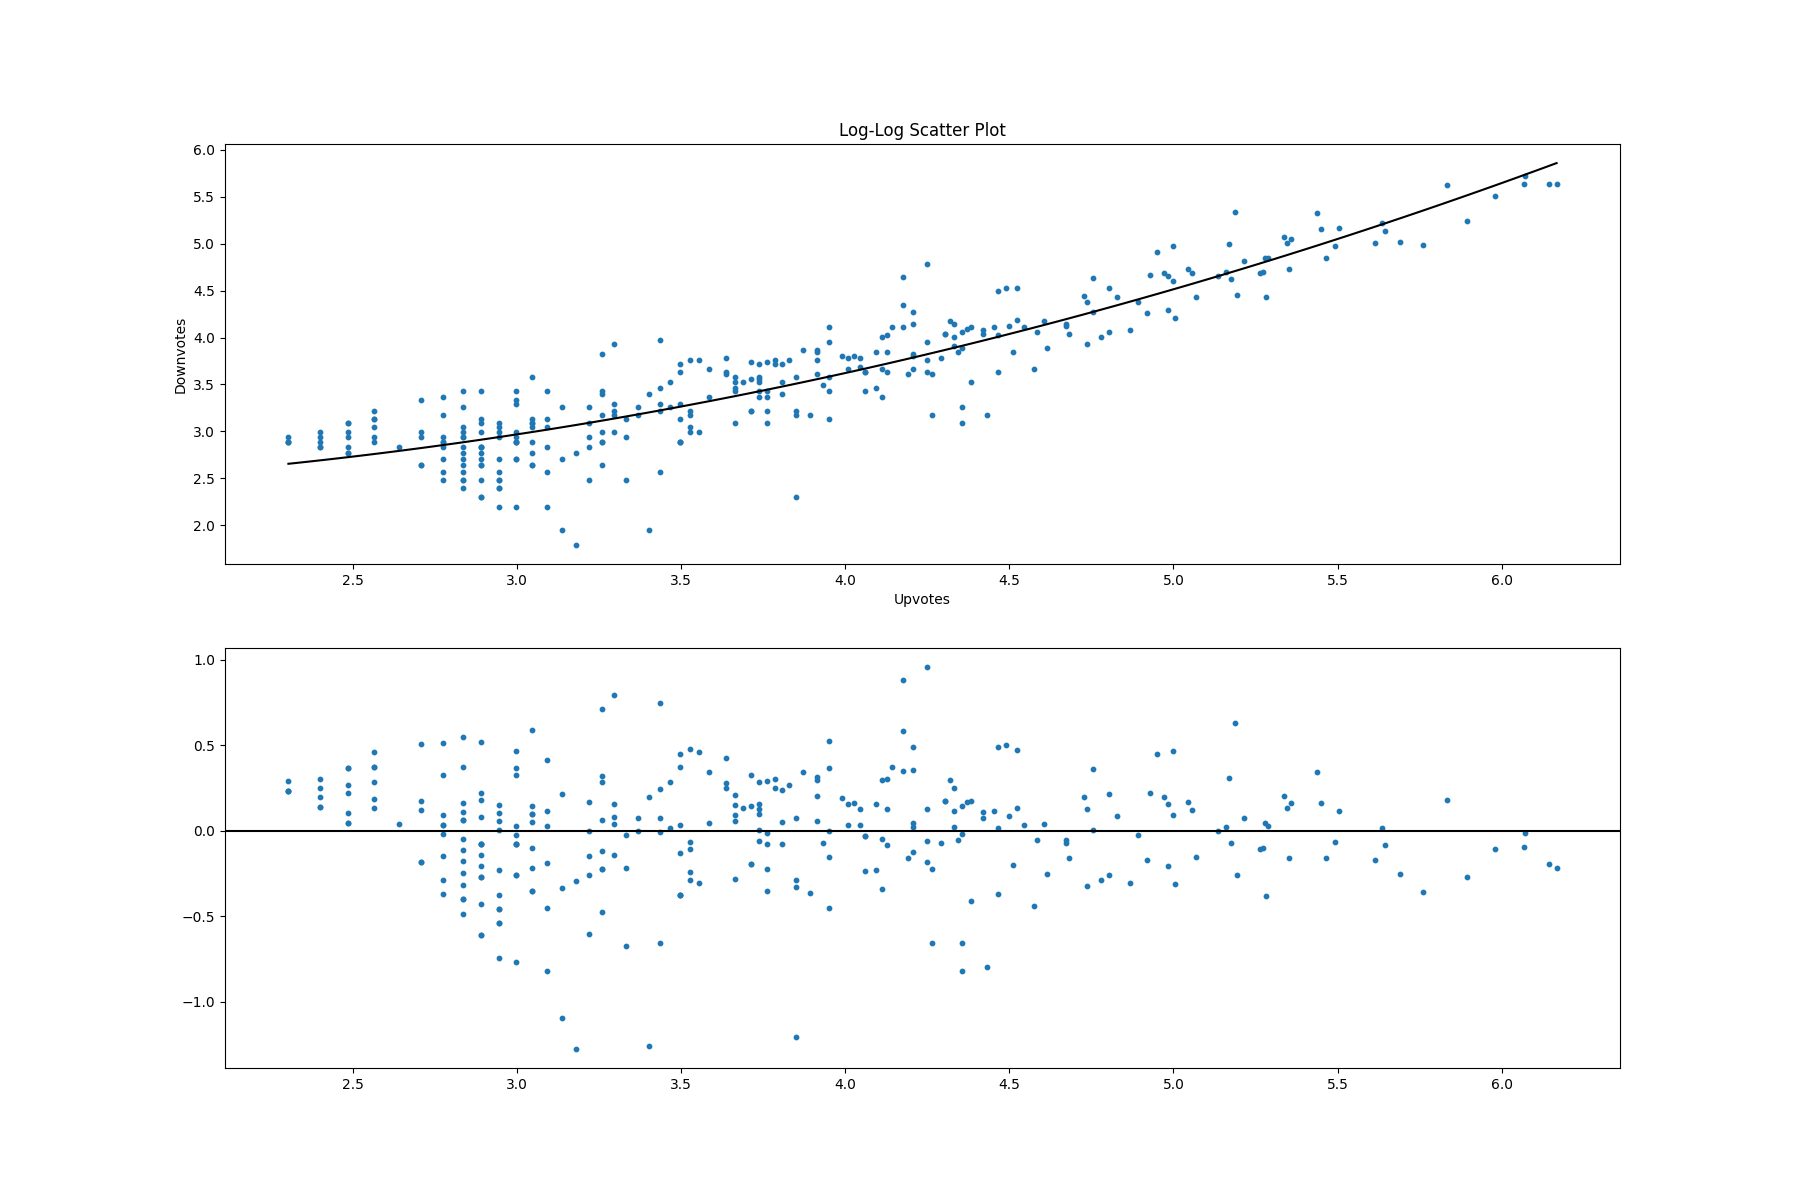

In [157]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import mplcursors

%matplotlib widget

# Make scatter plot
plt.close("all")
fig, ax = plt.subplots(2, figsize=(18, 12))
ax[0].set_title("Log-Log Scatter Plot")
ax[0].set(xlabel="Upvotes")
ax[0].set(ylabel="Downvotes")


def linear(x, m, b):
    return m * x + b


def logistic(x, L, k, d):
    return L / (1 + np.exp(-k * (x - d)))


def polynomial(x, a, b, c):
    return a * pow(x, 2) + b * x + c


y = df_combined["downvotes"]
y = y.apply(np.log)
x = df_combined["upvotes"]
x = x.apply(np.log)

params, covariance = curve_fit(polynomial, x, y)
sc1 = ax[0].scatter(x, y, s=10)
xhat = np.linspace(x.min(), x.max(), 100)
ax[0].plot(xhat, polynomial(xhat, *params), color="k")

df_combined["yhat"] = polynomial(x, *params)
residuals = y - df_combined["yhat"]
# df_combined.sort_values("residual", inplace=True)
# df_combined.reset_index(drop=True, inplace=True)
sc2 = ax[1].scatter(x, residuals, s=10)
ax[1].axhline(color="k")

# Add cursors
cursor1 = mplcursors.cursor(sc1, hover=True)
cursor2 = mplcursors.cursor(sc2, hover=True)


@cursor1.connect("add")
@cursor2.connect("add")
def on_add(sel):
    sel.annotation.set(text=df_combined["name"].iloc[sel.index])


# Show figure
plt.show()

In [158]:
df_combined.sort_values("upvotes").head()

,name,link,upvotes,downvotes,year,order,total_votes,ratio,inverse_order,bayes,yhat
532,Good Life Davidoff (male) ~ 1998,https://www.fragrantica.com/perfume/Davidoff/G...,10,19,1998,533,29,0.344828,123.0,0.410714,2.655698
512,Office For Men Fragrance One (male) ~ 2019,https://www.fragrantica.com/perfume/Fragrance-...,10,18,2019,513,28,0.357143,143.0,0.418182,2.655698
502,Black Leather by Honorine Blanc Mercedes-Benz ...,https://www.fragrantica.com/perfume/Mercedes-B...,10,18,2015,503,28,0.357143,153.0,0.418182,2.655698
501,212 VIP Black Extra Carolina Herrera (male) ~ ...,https://www.fragrantica.com/perfume/Carolina-H...,10,18,2019,502,28,0.357143,154.0,0.418182,2.655698
411,Just Rock! for Him Zadig & Voltaire (male) ~ 2017,https://www.fragrantica.com/perfume/Zadig-Volt...,11,17,2017,412,28,0.392857,244.0,0.436364,2.691725
